In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from math import atan2
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_CoM_acceleration
%store -r Y_motion_CoM_acceleration
%store -r X_motion_CoM_continuous
%store -r Y_motion_CoM_continuous

X_motion_CoM = np.vstack((X_motion_CoM_acceleration, X_motion_CoM_continuous))
Y_motion_CoM = np.vstack((Y_motion_CoM_acceleration, Y_motion_CoM_continuous))
print(X_motion_CoM.shape)
print(Y_motion_CoM.shape)

(13408, 28)
(13408, 2)


In [6]:
X_motion_CoM_continuous[0]

array([0.10000000149, 0.0, 0.0, 0.0436246310365, -0.0623315640547,
       0.0287474770733, 0.00923197799037, 0.00911098074187,
       0.0170479861481, 0.224820686714, 0.183767871704, -0.430754512842,
       0.242106336986, -0.169746484127, -0.431367276325, -0.237076912098,
       0.166767282807, -0.429774324185, -0.255938460943, -0.144975919339,
       -0.430475608633, True, False, False, True, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [7]:
Y_motion_CoM_continuous[0]

array([0.007738653999979306, 0.010271654219999427], dtype=object)

# Multivariate Linear Regression (CoM Prediction)

In [8]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [9]:
idx_fr_rl_swinging = np.where(X_motion_CoM[:, 22] == 1)[0]
X_motion_CoM_FR_RL = X_motion_CoM[idx_fr_rl_swinging]
Y_motion_CoM_FR_RL = Y_motion_CoM[idx_fr_rl_swinging]
print(X_motion_CoM_FR_RL.shape)
print(Y_motion_CoM_FR_RL.shape)

(6680, 28)
(6680, 2)


## Predict CoM (x) movement

In [10]:
X_motion_CoM_FR_RL[0, :]

array([0.10000000149, 0.0, 0.0, 0.065612523072, 0.126074603783,
       0.0115141802001, 0.000144907965681, 0.0222762428502,
       -0.00364215358762, 0.245064076011, 0.173711652046, -0.429870701809,
       0.228035356668, -0.187407596771, -0.430159975484, -0.269479530779,
       0.1372426258, -0.429456143731, -0.241380165069, -0.160313308797,
       -0.429952199155, False, True, True, False, 0.10000000149, 0.0, 0.0],
      dtype=object)

In [11]:
Y_motion_CoM_FR_RL[0, :]

array([0.0054835299120000736, -0.014639652615300001], dtype=object)

### Linear Regression

In [27]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))
               
# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 0]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_x = LinearRegression()

# Fit the model
model_fr_com_x.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9540548311184751
RMSE:  0.005877746184589742
The lowest error is:  2.5403555892894447e-07
The highest error is:  0.04426616272391512
The avg. error is:  0.003504680976878205


In [28]:
model_fr_com_x.coef_

array([[ 1.39592617e-02, -4.85722573e-16, -3.33066907e-16,
         1.14379344e-01, -2.35922393e-16,  2.77555756e-17,
        -1.40843453e-01,  6.77417303e-01,  4.29533576e-02,
        -1.57421891e-01,  3.14553022e-01,  1.66048966e-02,
         1.23737661e-01, -2.23919813e-02]])

In [29]:
model_fr_com_x.intercept_

array([-0.02127891])

In [30]:
input_ = np.array([[0.0,0.0,0.0,0.1,0.0,0.0, 0.237936324231, 0.188065700274, 0.234281409653, -0.171743092874, -0.249921495098, 0.161507381121, -0.259071586366, -0.138188475913]])
output = input_ @ model_fr_com_x.coef_.T + model_fr_com_x.intercept_
print(output)

[[0.01625116]]


Text(0, 0.5, 'Predictions')

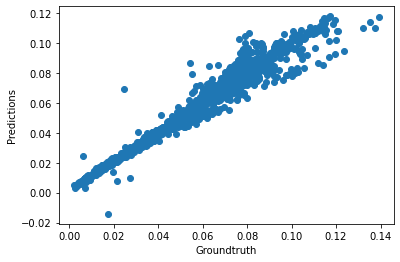

In [31]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [17]:
#%store model_fr_com_x

In [18]:
#for idx, prediction in enumerate(predictions):
#    print(f'Command: {X_test[idx, :3]}. Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [19]:
# Save model
#joblib.dump(model_fr_com_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_x.sav")

## Predict CoM -> y

### Linear Regression

In [20]:
# Input
X = np.hstack((X_motion_CoM_FR_RL[:, :3], # motion command
               X_motion_CoM_FR_RL[:, -3:], # motion command
               X_motion_CoM_FR_RL[:, 9:11], # FL (x,y) position
               X_motion_CoM_FR_RL[:, 12:14], # FR (x,y) position
               X_motion_CoM_FR_RL[:, 15:17], # RL (x,y) position
               X_motion_CoM_FR_RL[:, 18:20]))

# Labels
Y = np.array([Y_motion_CoM_FR_RL[:, 1]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, shuffle=True, random_state=100)

# Create the model
model_fr_com_y = LinearRegression()

# Fit the model
model_fr_com_y.fit(X_train, Y_train)

# Predict
predictions = model_fr_com_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.016101407342939855
RMSE:  0.0048306108708389296
The lowest error is:  1.4175773987434859e-06
The highest error is:  0.03590851919939847
The avg. error is:  0.0032767713508423334


In [21]:
model_fr_com_y.coef_

array([[-8.38359776e-03,  1.07552856e-16,  1.11022302e-16,
        -1.66422584e-02,  1.66533454e-16,  8.32667268e-17,
        -8.97730700e-03, -2.81181534e-01, -4.14680654e-01,
         4.18990517e-01,  3.08075395e-01,  6.46788629e-02,
         3.92182032e-01,  1.18417361e-01]])

In [22]:
model_fr_com_y.intercept_

array([0.39352244])

Text(0, 0.5, 'Predictions')

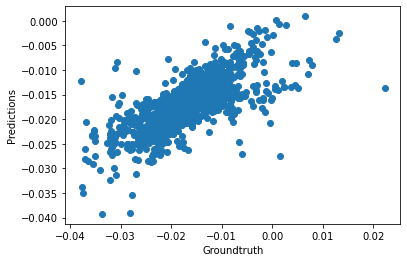

In [23]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("Groundtruth")
plt.ylabel("Predictions")

In [24]:
#%store model_fr_com_y

In [24]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [29]:
# Save model
#joblib.dump(model_fr_com_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_fr_com_y.sav")